In [1]:
# 0) importing libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as img

In [4]:
# 1) loading and filtering dataset
ds = pd.read_csv("../datasets/NYC_POIs/pois_all_info", index_col=False, sep="\t", low_memory=False)
ny_municipality = pd.read_csv("./NYC_POIs/ny_municipality_pois_id.csv", squeeze=True)
ds = ds.loc[~ds["@id"].duplicated()]
ds = pd.merge(ds, ny_municipality, on="@id")
print(ds)

              @id @type       @lat       @lon         amenity  \
0        42432939  node  40.814104 -73.949623             NaN   
1        42448838  node  40.761647 -73.949864             NaN   
2        42723103  node  40.852182 -73.772677  ferry_terminal   
3        42764076  node  40.867164 -73.882158             NaN   
4        42811266  node  40.704806 -73.772734             NaN   
...           ...   ...        ...        ...             ...   
53525  2553096114  node  40.736006 -73.713202             NaN   
53526  2553096138  node  40.736020 -73.713063             NaN   
53527  2553096143  node  40.736024 -73.713047             NaN   
53528  2553096154  node  40.736030 -73.713089             NaN   
53529  6146672068  node  40.735901 -73.713000             NaN   

                             name shop public_transport highway  
0                             NaN  NaN    stop_position     NaN  
1                             NaN  NaN    stop_position     NaN  
2      Hart Island Fe

In [4]:
# 2) counting missing values
missing_values =np.zeros(len(ds.columns))
for i in range(len(ds.columns)):
    missing_values[i] = ds[ds.columns[i]].isna().sum()
print(missing_values)

[    0.     0.     0.     0. 28818. 22980. 44813. 45154.]


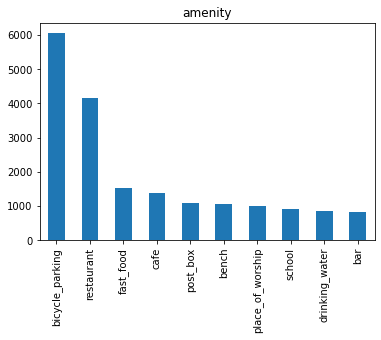

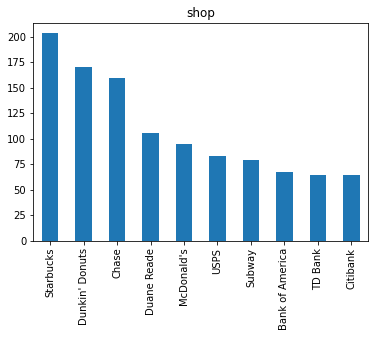

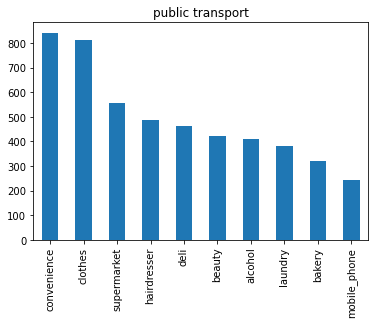

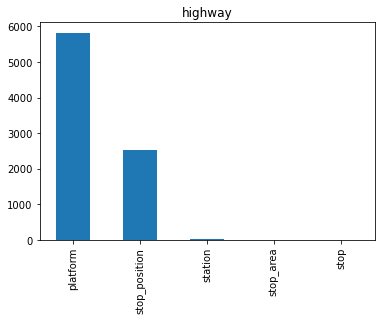

In [5]:
# 3) for each category plot a histogram showing types distribution
amenity = ds["amenity_name"].value_counts().sort_values(ascending=False)
shop = ds["shop"].value_counts().sort_values(ascending=False)
public_transport = ds["public_transport"].value_counts().sort_values(ascending=False)
highway = ds["highway"].value_counts().sort_values(ascending=False)

plt.figure(1)
amenity.iloc[:10].plot.bar()
plt.title("amenity")

plt.figure(2)
shop.iloc[:10].plot.bar()
plt.title("shop")

plt.figure(3)
public_transport.iloc[:10].plot.bar()
plt.title("public transport")

plt.figure(4)
highway.iloc[:10].plot.bar()
plt.title("highway")

plt.show()


/usr/lib64/python3.10/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


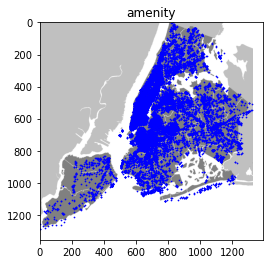

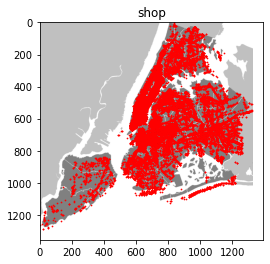

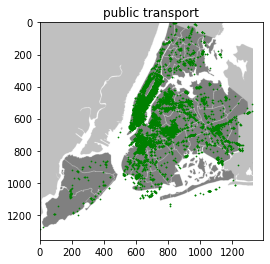

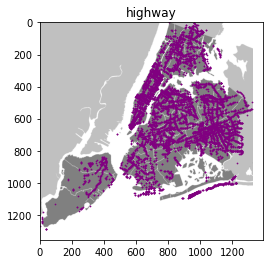

In [6]:
# 4) scatter plot in NY map image each point, different color for each category
def map_coordinates(locations, map_dimensions):
    min_lat = np.min(locations.loc[:, "@lat"].values)
    max_lat = np.max(locations.loc[:, "@lat"].values)
    min_lon = np.min(locations.loc[:, "@lon"].values)
    max_lon = np.max(locations.loc[:, "@lon"].values)
    locations.loc[:, "@lat_norm"] = (1-np.abs((locations.loc[:, "@lat"].values - min_lat) / (min_lat - max_lat))) * map_dimensions[0]
    locations.loc[:, "@lon_norm"] = np.abs((locations.loc[:, "@lon"].values - min_lon) / (min_lon - max_lon)) * map_dimensions[1]
    return locations
    
get_category_samples = lambda category_name: ds.loc[ds.loc[:, category_name].notnull()]
image_map = img.imread("./NYC_POIs/New_York_City_Map.PNG")

amenity_samples = map_coordinates(get_category_samples("amenity_name"), image_map.shape)
shop_samples = map_coordinates(get_category_samples("shop"), image_map.shape)
public_transport_samples = map_coordinates(get_category_samples("public_transport"), image_map.shape)
highway_samples = map_coordinates(get_category_samples("highway"), image_map.shape)

plt.figure(1)
plt.imshow(image_map)
plt.scatter(amenity_samples.loc[:, "@lon_norm"].values, amenity_samples.loc[:, "@lat_norm"].values, s=0.5, c="blue")
plt.title("amenity")

plt.figure(2)
plt.imshow(image_map)
plt.scatter(shop_samples.loc[:, "@lon_norm"].values, shop_samples.loc[:, "@lat_norm"].values, s=0.5, c="red")
plt.title("shop")

plt.figure(3)
plt.imshow(image_map)
plt.scatter(public_transport_samples.loc[:, "@lon_norm"].values, public_transport_samples.loc[:, "@lat_norm"].values, s=0.5, c="green")
plt.title("public transport")

plt.figure(4)
plt.imshow(image_map)
plt.scatter(highway_samples.loc[:, "@lon_norm"].values, highway_samples.loc[:, "@lat_norm"].values, s=0.5, c="purple")
plt.title("highway")

plt.show()

In [9]:
# 5) assign a cell_id to each sample
n = 8
cells_heigth = image_map.shape[0] / n
cells_width = image_map.shape[1] / n

get_id = lambda row: "x" + str(int(row["@lat_norm"] / cells_heigth)) + "y" + str(int(row["@lon_norm"] / cells_width))

amenity_samples.loc[:,"@cell_id"] = amenity_samples.apply(get_id, axis=1)
shop_samples.loc[:,"@cell_id"] = shop_samples.apply(get_id, axis=1)
public_transport_samples.loc[:,"@cell_id"] = public_transport_samples.apply(get_id, axis=1)
highway_samples.loc[:,"@cell_id"] = highway_samples.apply(get_id, axis=1)

/usr/lib64/python3.10/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [16]:
# 6) how many times a POI type is contained in each cell
types = set()
cells = set()
types = types.union(set(amenity_samples["amenity_name"].unique()))
types = types.union(set(shop_samples["shop"].unique()))
types = types.union(set(public_transport_samples["public_transport"].unique()))
types = types.union(set(highway_samples["highway"].unique()))
for i in range(n):
    for j in range(n):
        cells.add("x" + str(i) + "y" + str(j))

zero_datas = np.zeros((len(cells), len(types)))
df_counts = pd.DataFrame(zero_datas, index=cells, columns=types)

amenity_samples.groupby(by="@cell_id")